1. define exact regression line: 
    * $y^0 = f(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2$
2. define regression
    * $y = f(x) + \varepsilon(x)$
    * $\varepsilon(x)$ - not correlated errors with mean 0
    * where $ -1 \le x_1, x_2 \le 1$
    * $D(\varepsilon(x)) = D(\varepsilon(x_1, x_2)) = d(x_1, x_2)$
2. say, we are going to do experiment in 3 points: $x^{(1)} = (1, 1), x^{(2)} = (-1, 1), x^{(3)} = (-1, -1)$
3. set a-priori dispersions $d(x^{(1)}) = d_1, d(x^{(2)}) = d_2, d(x^{(3)}) = d_3$
4. according to the theorem, these must fullfill to create $D$-optimal plan:
    * $d(x_1, x_2) \ge d_{lower}(x_1, x_2)$, where
    * $d_{lower}(x_1, x_2) = \frac 1 4 (d_1 + d_3 + 2 d_1 x_1 - 2 d_3 x_2 - 2 d_2 x_1 x_2 + (d_1 + d_2)x_1^2 + (d_2 + d_3)x_2^2)$
    * $d(x^{(i)}) = d_{lower}(x^{(i)}) = d_i, i = \overline{1, 3}$
    
simulation:

0. f(x)
    * set $\theta_0, \theta_1, \theta_2$
    * implement f(x)
1. set $d_1, d_2, d_3$
2. generate $N$ points $(x_1, x_2)^{(i)} = x^{(i)}, i = \overline {1 ,N}$ from $R^2[0, 1]$
3. generate $\varepsilon_i$ from $N(0, d_{lower}(x^{(i)}; d_1, d_2, d_3)), i = \overline{1, N}$
4. generate $y_i = f(x^{(i)}) + \varepsilon_i$

test plan:

1. set N
2. generate experiment design with N/3 observations in each point
3. estimate $\hat \theta$ via WLS
4. compare optimal design estimates with random design estimates

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [3]:
thetas = np.array([2, 5, 1])
def f(X):
    return np.dot(X, thetas)

d1, d2, d3 = 6, 4 , 2

def d_lower(x1, x2, d1, d2, d3):
    return 1/4 * (d1 + d3 + 2*d1*x2 - 2*d3*x2 - 2*d2*x2 + (d1 + d2)*x1**2 + (d2 + d2)*x2**2)

In [2]:
points = np.array([
    [1, 1],
    [-1, 1],
    [-1, -1]
])

In [4]:
n_trials = 5
results = []

np.random.seed(42)

def make_y(X):
    N = X.shape[0]
    error_dispersions = d_lower(X[:, 1], X[:, 2], d1, d2, d3)
    errors = np.random.normal(0, np.sqrt(error_dispersions), N)
    return f(X) + errors 

N_test = 100
X_test = np.random.uniform(-1, 1, (N_test, 2))
X_test = np.concatenate([np.ones((N_test, 1)), X_test], axis=1)
y_test = make_y(X_test)

# Ns = np.power(4, np.arange(0, 5)) * 3
Ns = np.arange(1, 10) * 3
for _ in range(n_trials):
    for N in Ns:
        result = {
            'N': N
        }
        Xs = [
            ('optimal', np.repeat(points, N / 3, axis=0)),
            ('random', np.random.uniform(-1, 1, (N, 2)))
        ]
        for name, X in Xs:
            X = np.concatenate([np.ones((N, 1)), X], axis=1)
            y = make_y(X)
            error_dispersions = d_lower(X[:, 1], X[:, 2], d1, d2, d3)
            weights = 1 / error_dispersions
            wls_estimator = LinearRegression(fit_intercept=False).fit(X, y, weights)
            result[f'theta_{name}_mse'] = mean_squared_error(thetas, wls_estimator.coef_)
            result[f'y_{name}_mse'] = mean_squared_error(y_test, wls_estimator.predict(X_test))
        results.append(result)
    
df = pd.DataFrame(results)

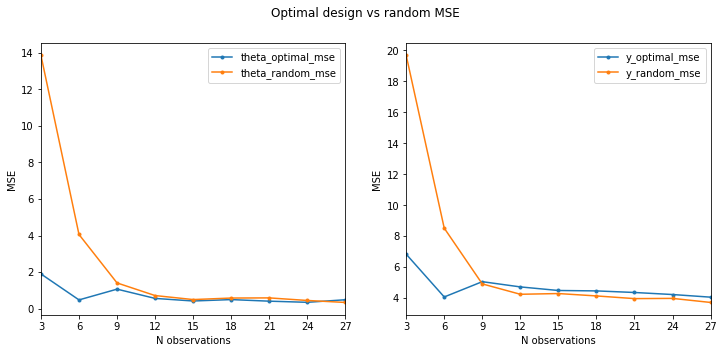

In [5]:
df_agg = df.groupby('N').agg('mean')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, param in zip(axes, ['theta', 'y']):
    columns = df_agg.columns.str.startswith(param)
    df_agg.loc[:, columns].reset_index(drop=True).plot(style='.-', ax=ax)
    ax.set_xticklabels(Ns);
    ax.set_xlabel('N observations')
    ax.set_ylabel('MSE')
fig.suptitle('Optimal design vs random MSE');

In [6]:
df_agg[['theta_optimal_mse', 'theta_random_mse', 'y_optimal_mse', 'y_random_mse']]

,theta_optimal_mse,theta_random_mse,y_optimal_mse,y_random_mse
N,,,,
3,1.899395,13.862424,6.844021,19.684487
6,0.478233,4.057797,4.082045,8.525354
9,1.066543,1.407026,5.069288,4.925320
12,0.560250,0.715677,4.731304,4.255489
15,0.418269,0.496861,4.499994,4.302376
18,0.495404,0.580043,4.473083,4.148203
21,0.408860,0.587857,4.371155,3.975373
24,0.346498,0.447236,4.239258,3.989631
27,0.486753,0.339060,4.069151,3.727942
